#### Faster-RCNN for Object Detection <br>
In this notebook we will train faster-rcnn model for object detection on a simple dataset. The dataset we will use is [fruits dataset](https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection) which contains three fruits i.e., apple, banana and orange. The code we will use can be found [here](https://github.com/you359/Keras-FasterRCNN). <br>

The summary of Faster-RCNN is described as following: <br>
(*from this [blog](https://www.analyticsvidhya.com/blog/2018/11/implementation-faster-r-cnn-python-object-detection/)*) <br>

1. Take an input image and pass it to the ConvNet which returns feature maps for the image <br>
2. Apply Region Proposal Network (RPN) on these feature maps and get object proposals <br>
3. Apply ROI pooling layer to bring down all the proposals to the same size <br>
4. Finally, pass these proposals to a fully connected layer in order to classify any predict the bounding boxes for the image <br>

The summarized architecture of Faster-RCNN is shown below: <br>
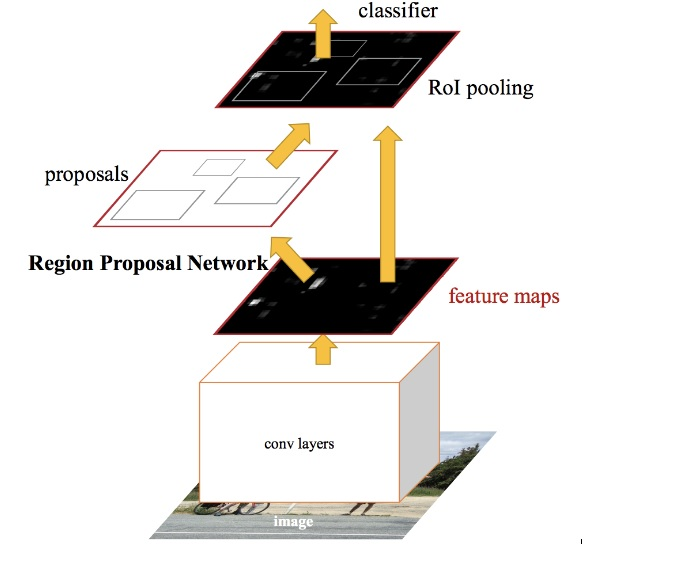

### Implementation:

In [1]:
cd drive/MyDrive/Computer\ Vision\ CS-867\ TAship/Faster-RCNN/

/content/drive/MyDrive/Computer Vision CS-867 TAship/Faster-RCNN


#### Preprocessing <br>
The [dataset](https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection) we are using contains train an test images with labels as .xml file for each image. We need to give our model a .txt file where each line contains `filepath,x1,y1,x2,y2,class_name`, where: <br>
`filepath` is the path of the training image <br>
`x1` is the xmin coordinate for bounding box <br>
`y1` is the ymin coordinate for bounding box <br>
`x2` is the xmax coordinate for bounding box <br>
`y2` is the ymax coordinate for bounding box <br>
`class_name` is the name of the class in that bounding box <br>

So, we will first save the all the labels in a .csv file and then convert the .csv to .txt for both train and test sets. Also, separate the images and annotations by moving annotation files from original folder to new folder so that the original folder only has images. <br>

Download the [dataset](https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection) and unzip in a folder. I have saved in `dataset/fruits/` directory.

In [26]:
data_dir = 'dataset/fruits/'

In [3]:
%pylab inline

import os, sys, random
import xml.etree.ElementTree as ET
from glob import glob
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [17]:
# select all .xml files from train and test folders
train_annotations = glob(data_dir+'train_zip/train/*.xml')
test_annotations = glob(data_dir+'test_zip/test/*.xml')

In [19]:
# function to save all xml labels into single csv file
def xml_to_csv(annotations, annotation_file_name):
  df = []
  for file in annotations:
    filename = file.split('/')[-1].split('.')[0] + '.jpg'
    row = []
    parsedXML = ET.parse(file)
    for node in parsedXML.getroot().iter('object'):
      class_name = node.find('name').text
      xmin = int(node.find('bndbox/xmin').text)
      xmax = int(node.find('bndbox/xmax').text)
      ymin = int(node.find('bndbox/ymin').text)
      ymax = int(node.find('bndbox/ymax').text)

      row = [filename, class_name, xmin, xmax,
      ymin, ymax]
      df.append(row)

  data = pd.DataFrame(df, columns=['filename', 'class_name',
  'xmin', 'xmax', 'ymin', 'ymax'])

  data[['filename', 'class_name', 'xmin', 
        'xmax', 'ymin', 'ymax']].to_csv(annotation_file_name, index=False)

In [20]:
xml_to_csv(train_annotations, 'train.csv')
xml_to_csv(test_annotations, 'test.csv')

Rename the train and test folders to `train_images` and `test_images`. Move all .xml annotation files to another folder from both train and test folders so that they contain only images. To move you can use this script: <br>
```
import shutil

for file in annotations:
  filename = file.split('/')[-1]
  shutil.move('train_images/'+filename, 'train_labels')
for file in test_annotations:
  filename = file.split('/')[-1]
  shutil.move('test_images/'+filename, 'test_labels')
```



Next, we will convert the .csv file to required .txt format.

In [21]:
# read the csv file using read_csv function of pandas
train = pd.read_csv('train.csv')
train.head()

,filename,class_name,xmin,xmax,ymin,ymax
0,apple_1.jpg,apple,8,331,15,349
1,apple_10.jpg,apple,56,1413,99,1419
2,apple_11.jpg,apple,213,459,33,258
3,apple_11.jpg,apple,1,188,30,280
4,apple_11.jpg,apple,116,337,5,220


In [22]:
# number of unique training examples
train['filename'].nunique()

240

In [27]:
# number of classes
train['class_name'].value_counts()

banana    169
apple     156
orange    140
Name: class_name, dtype: int64

In [ ]:
# converting the .csv format to required .txt format
data = pd.DataFrame()
data['format'] = train['filename']

# as the images are in train_images folder, add train_images before the image name
for i in range(data.shape[0]):
    data['format'][i] = 'train_images/' + data['format'][i]

# add xmin, ymin, xmax, ymax and class as per the format required
for i in range(data.shape[0]):
    data['format'][i] = data['format'][i] + ',' + str(train['xmin'][i]) + ',' + str(train['ymin'][i]) + ',' + str(train['xmax'][i]) + ',' + str(train['ymax'][i]) + ',' + train['class_name'][i]

data.to_csv('annotate.txt', header=None, index=None, sep=' ')

In [48]:
test = pd.read_csv('test.csv')

In [49]:
test.head()

,filename,class_name,xmin,xmax,ymin,ymax
0,apple_77.jpg,apple,71,175,60,164
1,apple_77.jpg,apple,12,105,22,111
2,apple_77.jpg,apple,134,243,23,115
3,apple_77.jpg,apple,107,216,126,229
4,apple_77.jpg,apple,207,298,138,229


In [50]:
# converting the test.csv format to .txt
data = pd.DataFrame()
data['format'] = test['filename']

# as the images are in test_images folder, add test_images before the image name
for i in range(data.shape[0]):
    data['format'][i] = 'test_images/' + data['format'][i]

# add xmin, ymin, xmax, ymax and class as per the format required
for i in range(data.shape[0]):
    data['format'][i] = data['format'][i] + ',' + str(test['xmin'][i]) + ',' + str(test['ymin'][i]) + ',' + str(test['xmax'][i]) + ',' + str(test['ymax'][i]) + ',' + test['class_name'][i]

data.to_csv('test_annotate.txt', header=None, index=None, sep=' ')

Now we have annotations in .txt file in required format. <br>

#### Clone implementation of Faster-RCNN

In [ ]:
! git clone https://github.com/you359/Keras-FasterRCNN

After cloning this repo. move the `train_images` and `test_images` as well as `annotate.txt` to cloned repo/ folder for training.

cd to the cloned repo:

In [4]:
cd Keras-FasterRCNN/

/content/drive/MyDrive/Computer Vision CS-867 TAship/Faster-RCNN/Keras-FasterRCNN


### Training

If working on your machine install requirements.txt using <br> `pip install -r requirements.txt`. <br>

If working on colab, just do the following steps, since this repo is using tensorflow version 1.x and keras version 2.0.3.


In [6]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!pip install keras==2.0.3

In [10]:
import keras
keras.__version__

'2.0.3'

Let's start training. We will be using train_frcnn.py to train. I have specified number of epochs = 20, n=16 which is no. of ROIs to process at once.

In [6]:
! python train_frcnn.py -o simple -p annotate.txt --num_epochs 20 -n 16

Using TensorFlow backend.
Parsing annotation files
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Training images per class:
{'apple': 156, 'banana': 169, 'bg': 0, 'orange': 140}
Num classes (including bg) = 4
Config has been written to config.pickle, and can be loaded when testing to ensure correct results
Num train samples 200
Num test samples 40







Instructions for updating:
keep_dims is deprecated, use keepdims instead
loading weights from resnet50_weights_tf_dim_ordering_tf_kernels.h5
Could not load pretrained model weights. Weights can be found in the keras application folder         https://github.com/fchollet/keras/tree/master/keras/applications


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
keep_dims is deprecated, use keepdims instead



2021-

#### Testing

The following command will run the test on test images using the model with above trained weights. Results will be save in a `results_imgs` folder.

In [11]:
! python test_frcnn.py -p test_images/

Using TensorFlow backend.

{0: 'apple', 1: 'banana', 2: 'orange', 3: 'bg'}






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Loading weights from ./model_frcnn.hdf5



2021-01-21 10:34:46.991188: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2199995000 Hz
2021-01-21 10:34:46.991489: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xb05e1c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-01-21 10:34:46.991526: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-01-21 10:34:46.996401: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-01-21 10:34:47.196172: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-01-21

### Visualizing Results <br>
Let's randomly select some images and see how the model has predicted.


In [19]:
import random
import os
results = 'results_imgs/'

['7.png', '28.png', '14.png', '17.png', '43.png']

In [27]:
imgs_to_display = random.sample(os.listdir(results), 5)

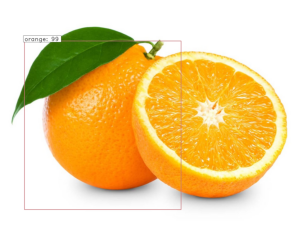

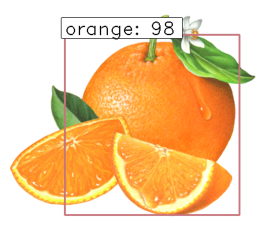

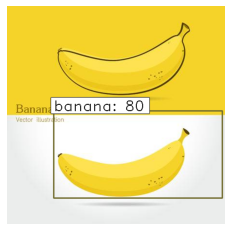

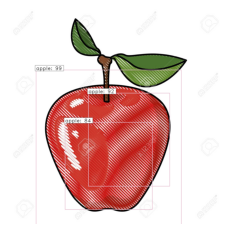

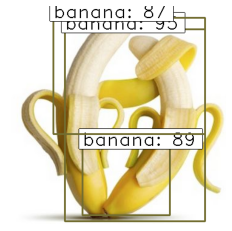

In [28]:
import matplotlib.pyplot as plt
import PIL
%matplotlib inline

for num, x in enumerate(imgs_to_display):
    plt.figure()
    img = PIL.Image.open(results+x)
    plt.axis('off')
    plt.imshow(img)
